# BEES3041: Modelling the photosynthetic response to environmental conditions

![](data/logo.jpeg)

# Introduction

In this lab we are going to explore the C~3~ leaf-level photosynthesis model proposed by @Far80 and use this to simulate photosynthesis at leaf and ecosystem scales. As we saw in the lecture, the photosynthesis model is central to all land schemes embedded in coupled-climate model. The model predicts that photosynthesis is limited by the slowest of three biochemical processes:

  1. The maximum rate of Rubisco-catalysed carboxylation (Ac)
  2. The rate of ribulose 1,5-bisphosphate (RuBP) regeneration via electron transport (Aj)
  3. The rate of RuBP regeneration via triose phosphate utilisation (Ap)

In this practical we are only going to consider the first two limitations. There a number of great papers which cover this subject in detail, see for example, @Ber13, @Med02 and @Sha85.

We are going to use the photosynthesis model to:

* learn how leaf-level photosynthesis responds to changes in the environmental forcing (photosynthetically active radiation, temperature and carbon dioxide).
* simulate GPP at the ecosystem-scale (~1 km^2) using FLUXNET (eddy covariance) meteorological data.
* build a simpler GPP model and apply this at the ecosystem scale.

From playing with these model we should start to see the key assumptions that our models make. We should also begin to identify the key weakness in our approach as we apply the model at different scales. We should also start to build an understanding that would allow us to predict how vegetation will respond to global change.

***

# Temperature response of model parameters

Let's start by exploring the response of the model to temperature. First we need to generate some temperature data:

In [1]:
#%matplotlib notebook
%matplotlib inline

import sys
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd 

sys.path.append("python")
from farq import FarquharC3
from lue import calc_lue
import constants as c
import parameters as p

In [2]:
Tleaf = np.arange(0, 50.0+1.0) 
TleafK = Tleaf + c.DEG_2_KELVIN

In [3]:
print(Tleaf)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50.]


The biochemical reactions in the model depend on temperature because enzyme activity is temperature dependent. The photosynthesis model has two major parameters, the potential rate of electron transport ($J_{max}$) and the maximum rate of Rubisco activity ($V_{cmax}$). Both of these parameters vary as a function of temperature and it is common practice to use the peaked Arrhenius equation to express the rate of the process. 

Let's plot $V_{cmax}$ and $J_{max}$. I've copied the function calls from python/farq.py:

In [9]:
F = FarquharC3(peaked_Jmax=True, peaked_Vcmax=True, gs_model="medlyn")

In [10]:
Vcmax = F.peaked_arrh(p.Vcmax25, p.Eav, TleafK, p.deltaSv, p.Hdv)
Jmax = F.peaked_arrh(p.Jmax25, p.Eaj, TleafK, p.deltaSj, p.Hdj)

Text(0.5, 0, 'Temperature ($^{\\circ}$C)')

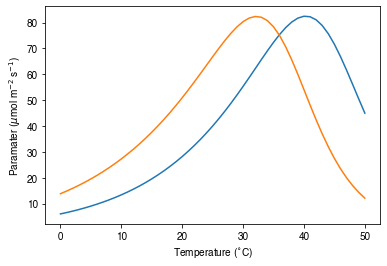

In [11]:
plt.plot(Tleaf, Vcmax)
plt.plot(Tleaf, Jmax)
plt.ylabel("Paramater ($\mu$mol m$^{-2}$ s$^{-1}$)")
plt.xlabel("Temperature ($^{\circ}$C)")

In the model both parameters are modelled using a peaked form (i.e. there is an optimum temperature) of the Arrhenius equation. What would we see if we used a standard Arrhenius equation? 

The Eav/Eaj parameters give the exponential increase of the function below the optimum (before the reaction can proceed, the substrate must be raised to its activation energy); the Hdv/Hdj parameters describe the rate of decrease of the function above the optimum.

**Q. Can you work out what parameter values you used?**

Answer:

In [12]:
print(p.Vcmax25, p.Eav, p.deltaSv, p.Hdv)
print(p.Jmax25, p.Eaj, p.deltaSj, p.Hdj)

40.0 51560.0 629.26 200000.0
66.8 43790.0 644.4338 200000.0


**Q. Can you now tweak these values and explore how the functions respond to temperature?**

Answer: 

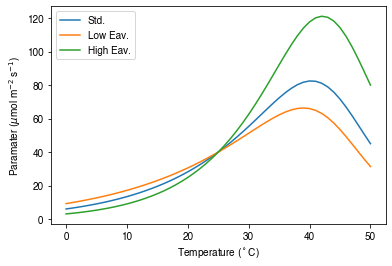

In [13]:
Vcmax2 = F.peaked_arrh(p.Vcmax25, 40000., TleafK, p.deltaSv, p.Hdv)
Vcmax3 = F.peaked_arrh(p.Vcmax25, 70000., TleafK, p.deltaSv, p.Hdv)

plt.plot(Tleaf, Vcmax, label="Std.")
plt.plot(Tleaf, Vcmax2, label="Low Eav.")
plt.plot(Tleaf, Vcmax3, label="High Eav.")
plt.legend(numpoints=1, loc="best")
plt.ylabel("Paramater ($\mu$mol m$^{-2}$ s$^{-1}$)")
plt.xlabel("Temperature ($^\circ$C)")
plt.show()

In the model, the Rubisco-limited photosynthesis rate:

$$A_{c} = \frac{V_{cmax}(C_{i} - \Gamma^*)}{C_{i} + K_{c}(1 + Oi / K_{o})}$$

is made up of four parameters that are temperature dependent.
  
  1. $\Gamma$$^{*}$: the CO~2~ compensation point in the absence of mitochondrial respiration.
  2. $V_{cmax}$: the maximum rate of Rubisco activity.
  3. $K_{o}$: Michaelis– Menten coefficients for oxygenation.
  4. $K_{c}$: Michaelis– Menten coefficients for carboxylation.

The skill of the model depends on correctly accounting for these responses to temperature when using the model. When we use these model parameters in global models we typical assume that the parameters (excluding V~cmax~) are conserved across species. This assumption is broadly supported by observations.

By contrast, leaf measurements suggest that V~cmax~ varies considerably: varying between leaves within a single plant, across growing seasons and across plants. In global models, we typically assume that we can represent this variability using 5-11 plant functional types, see @Rog14 for more details. Even when we do this in models, the disagreement across models is striking.

![](data/rogers.png)


**Q. What impact do you think this variability will have on model simulations of GPP?**

**Q. Now that you've seen how to call the functions to calculate $V_{cmax}$ and $J_{max}$, can you look in the code (python/farq.py) and also plot one of: $\Gamma$$^{*}$, $K_{c}$ and $K_{o}$ as a function of temperature?**
  
Answer:

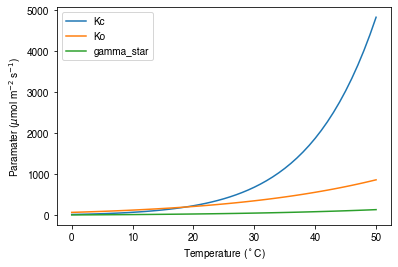

In [14]:
Kc = F.arrh(p.Kc25, p.Ec, TleafK)
Ko = F.arrh(p.Ko25, p.Eo, TleafK)
gamma_star = F.arrh(p.gamstar25, p.Eag, TleafK)

plt.plot(Tleaf, Kc, label="Kc")
plt.plot(Tleaf, Ko, label="Ko")
plt.plot(Tleaf, gamma_star, label="gamma_star")
plt.legend(numpoints=1, loc="best")
plt.ylabel("Paramater ($\mu$mol m$^{-2}$ s$^{-1}$)")
plt.xlabel("Temperature ($^\circ$C)")
plt.show()

# Response to temperature

**Q. From your new understanding of how the key model parameters change with temperature, can you predict how the rate of photosynthesis is likely to change with temperature?**

**Q. Can you make a plot to see if your prediction matched the models? (hint ... You will need to call the calc_photosynthesis function)**

Answer:

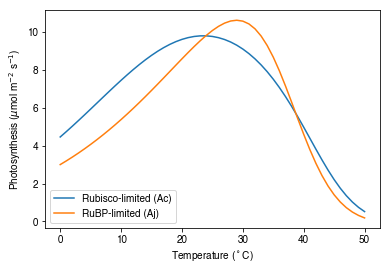

In [10]:
PAR = 1800.0
Cs = 400.0
vpd = 1.5

(An, Ac, Aj, gsw, Rd) = F.photosynthesis(p, Cs, TleafK, PAR, vpd)

plt.plot(Tleaf, Ac-Rd, label="Rubisco-limited (Ac)")
plt.plot(Tleaf, Aj-Rd, label="RuBP-limited (Aj)")
plt.legend(numpoints=1, loc="best")
plt.ylabel("Photosynthesis ($\mu$mol m$^{-2}$ s$^{-1}$)")
plt.xlabel("Temperature ($^\circ$C)")
plt.show()

The plot shows that the response of A to temperature increases steadily until it reaches an optimum point (T~opt~), after which A declines at a faster rate.

The model assumes that the Rubisco-limited assimilation rate follows a Michaelis–Menten response function, accounting for a competitive inhibitor, oxygen. 

With Michaelis-Menten reactions: 
    1. increasing the limiting substrate, CO~2~; 
    2. the amount of enzyme present, Rubisco; and/or 
    3. decreasing the competitive inhibitor, O~2~, will yield higher reaction rates. 
    
The model also assumes that the RuBP regeneration-limited rate of assimilation, Aj:

$$A_{j} = \frac{J}{4}\bigg(\frac{C_{i} - \Gamma^*}{C_{i} + 2 \Gamma^*}\bigg)$$

depends on the rate at which the light reactions generate ATP and NADPH; this process is limited at low light intensity.

**Q. Can you increase and decrease the intercellular concentration of the O~2~ parameter (O~i~) and plot the impact. Does your plot fit with what I wrote above?**

Answer:

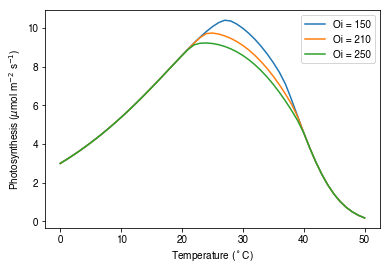

In [11]:
p.Oi = 150.0
(An_low, __, __, __, __) = F.photosynthesis(p, Cs, TleafK, PAR, vpd)

p.Oi = 250.0
(An_high, __, __, __, __) = F.photosynthesis(p, Cs, TleafK, PAR, vpd)

p.Oi = 210.0
(An_std, __, __, __, __) = F.photosynthesis(p, Cs, TleafK, PAR, vpd)

plt.plot(Tleaf, An_low, label="Oi = 150")
plt.plot(Tleaf, An_std, label="Oi = 210")
plt.plot(Tleaf, An_high, label="Oi = 250")
plt.legend(numpoints=1, loc="best")
plt.ylabel("Photosynthesis ($\mu$mol m$^{-2}$ s$^{-1}$)")
plt.xlabel("Temperature ($^\circ$C)")
plt.show()

***

## Response to PAR

At low PAR, A is RUBP regeneration-limited due to the low rates of electron transport. The slope of the inital portion of the A/PAR curve is referred to as the quantum efficieicy of CO~2~ assimilation (see alpha parameter). As light increases, the rapid increase of A with PAR begins to diminsh. The rate this occurs at depends on what we assumed for the curvuture parameter (theta_J).

**Q. Can you vary PAR and plot the response of A (hint ... see how you made an array of temperature)?**

**Q. Can you explore the sensitivity of the A-PAR relationship to alpha and theta_J parameters?**

Answer:

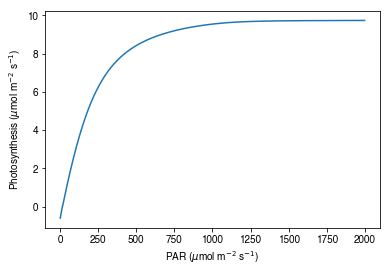

In [12]:
TleafK = 25.0 + c.DEG_2_KELVIN
PAR = np.arange(0.0, 2000.0)
Cs = 400.
vpd = 1.5

(An, Ac, Aj, gsw, Rd) = F.photosynthesis(p, Cs, TleafK, PAR, vpd)

plt.plot(PAR, An, label="An")
plt.ylabel("Photosynthesis ($\mu$mol m$^{-2}$ s$^{-1}$)")
plt.xlabel("PAR ($\mu$mol m$^{-2}$ s$^{-1}$)")
plt.show()

***

## Response to CO~2~

At low [CO~2~] concentrations, photosynthesis is Rubisco-limited except for when PAR is also low. With inceasing [CO~2~], A increases until an inflection point is reached where A is said to be co-limited by Rubisco and RuBP regeneration.

**Q. Can you vary [CO~2~] and plot the response of A?**

Answer:

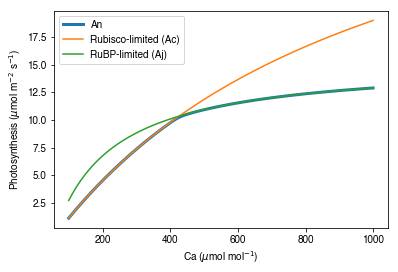

In [13]:
TleafK = 25.0 + c.DEG_2_KELVIN
PAR = 1800.0
Cs = np.arange(100., 1000.0, 0.5)
vpd = 1.5

(An, Ac, Aj, gsw, Rd) = F.photosynthesis(p, Cs, TleafK, PAR, vpd)

plt.plot(Cs, An, label="An", lw=3)
plt.plot(Cs, Ac-Rd, label="Rubisco-limited (Ac)")
plt.plot(Cs, Aj-Rd, label="RuBP-limited (Aj)")
plt.legend(numpoints=1, loc="best")
plt.ylabel("Photosynthesis ($\mu$mol m$^{-2}$ s$^{-1}$)")
plt.xlabel("Ca ($\mu$mol mol$^{-1}$)")
plt.show()

***

## Ecosystem scale

Let's now apply the leaf-level model at a coarser spatial scale and compare our model simulations to measured data. In doing so, try and keep in mind the assumptions we are making. Can we explain any model-data disagreements based on these.

To apply the leaf-level model at a km^2^ scale, we are going to use a big-leaf approximation to scale up our leaf-level model. We are going to assume that:

$$APAR = PAR * fPAR$$

where

$$fPAR = (1.0 - exp(-k * LAI)) / k$$
and k=0.5.

Across the globe there is large network of sites (~900) with meteorological sensors measuring a range of variables (e.g. temperature, humidity, wind speed, rainfall) on a continuous basis. At each of these sites, the eddy covariance method is also used to measure the exchange of carbon dioxide, energy and water vapour fluxes between the vegetation and soils and the atmosphere. These data are freely avaliable at a number of sites (but not all!) under a release called FLUXNET2015 (https://fluxnet.fluxdata.org/).

The original data from FLUXNET aren't readily useable by land surface models. These data must be first transformed into a LSM-readable file format - [NetCDF](https://www.unidata.ucar.edu/software/netcdf/), apply some unit corrections and be screened and gap-filled, where necessary. Fortunately [Anna Ukkola at UNSW](https://www.ccrc.unsw.edu.au/ccrc-team/alumni/anna-ukkola) has done all the heavy lifting here, so we will data that has been corrected by her [R package](https://www.geosci-model-dev.net/10/3379/2017/).

NetCDF files are the gold standard for the climate community as they are a self describing format that allows you to associate many layers of metadata with a binary file that wouldn't be possible with a text file. To be able to read these data we are going to have to use a NetCDF library and learn a few new commands...

In [14]:
fname = "data/FR-Pue_2002-2003_FLUXNET2015_Met.nc"
ds = xr.open_dataset(fname)
ds

<xarray.Dataset>
Dimensions:       (time: 35040, x: 1, y: 1)
Coordinates:
  * time          (time) datetime64[ns] 2002-01-01 ... 2003-12-31T23:30:00
  * x             (x) float64 1.0
  * y             (y) float64 1.0
Data variables:
    Tair          (time, y, x) float32 ...
    Tair_qc       (time, y, x) float32 ...
    SWdown        (time, y, x) float32 ...
    SWdown_qc     (time, y, x) float32 ...
    LWdown        (time, y, x) float32 ...
    LWdown_qc     (time, y, x) float32 ...
    VPD           (time, y, x) float32 ...
    Qair          (time, y, x) float32 ...
    VPD_qc        (time, y, x) float32 ...
    Psurf         (time, y, x) float32 ...
    Precip        (time, y, x) float32 ...
    Wind          (time, y, x) float32 ...
    RH            (time, y, x) float32 ...
    Psurf_qc      (time, y, x) float32 ...
    Precip_qc     (time, y, x) float32 ...
    Wind_qc       (time, y, x) float32 ...
    RH_qc         (time, y, x) float32 ...
    latitude      (y, x) float32 ...

Let's query the lat and lon:

In [15]:
print(ds.latitude.values[0], ds.longitude.values[0])

[43.7413] [3.5957]


Now let's extract the data we need to run our leaf model:

In [16]:
df = ds.squeeze(dim=["x","y"], drop=True).to_dataframe()
df = df.reset_index()
df = df.set_index('time')

Tair = df.Tair
vpd = df.VPD
SWdown = df.SWdown

**Q. Can you get also get the wind and precipitation variables?**

Answer:

In [17]:
Wind = df.Wind
Precip = df.Precip

It is good practice to clean up when we're done with the NetCDF file.

In [18]:
ds.close()

It is a good idea to make a sanity plot at this point, garbage into a model leads to garbage out...

**Q. Can you plot Tair for the first year (the timestep of the data is 30 mins)?**

Answer:

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


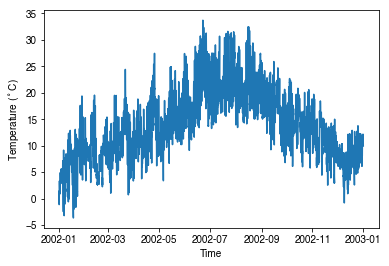

In [19]:
# Just plot the first year
plt.plot(Tair.index[0:48*365], Tair[0:48*365]-c.DEG_2_KELVIN)
plt.ylabel("Temperature ($^\circ$C)")
plt.xlabel("Time")
plt.show()

LSMs typically use SWdown, so we will need to convert this to PAR and for our big-leaf scaling we also need to transform this to APAR using the equations we outlined above.

In [20]:
LAI = 1.5
fPAR = (1.0 - np.exp(-p.k * LAI)) / p.k
df["APAR"] = (SWdown * c.SW_2_PAR) * fPAR
Cs = 400.0

(An, Ac, Aj, gsw, Rd) = F.photosynthesis(p, Cs, df.Tair, df.APAR, df.VPD)

Plotting half-hourly output will be a bit much, so let's generate daily output

In [21]:
# Let's convert from 30 mins to daily sums as these will be easier to view.
conv = c.UMOL_TO_MOL * c.MOL_C_TO_GRAMS_C * c.SEC_2_HLFHR

df_mod = pd.DataFrame(data=An * conv, index=df.index, columns=["GPP"])
df_mod = df_mod.resample("D").sum()

**Q. Can you plot the model output?**

Answer:

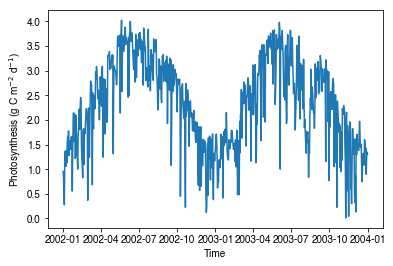

In [22]:
plt.plot(df_mod.GPP, label="An")
plt.ylabel("Photosynthesis (g C m$^{-2}$ d$^{-1}$)")
plt.xlabel("Time")
plt.show()

OK we've now modelled some GPP based on real data, it is time to see how sensible our model simulation was! Let's compare the model output to the flux derived GPP. It is important to note that GPP isn't measured at flux sites, but is derived from other measurements; however, for the purposes of this practical you can view it is as a set of observations.

**Q. Can you use the previous logic to load the flux file and extract the GPP variable and make a dataframe?**

Answer:

In [23]:
fname = "data/FR-Pue_2002-2003_FLUXNET2015_Flux.nc"
ds = xr.open_dataset(fname)
df_flx = ds.squeeze(dim=["x","y"], drop=True).to_dataframe()
df_flx = df_flx.reset_index()
df_flx = df_flx.set_index('time')
ds.close()

**Q. Can you turn the observation data into daily data?**

**Q. Can you plot the obs and the model?**

Answer:

In [24]:
df_obs = pd.DataFrame(data=df_flx.GPP, index=df_flx.index, columns=["GPP"])
df_obs *= conv
df_obs = df_obs.resample("D").sum()

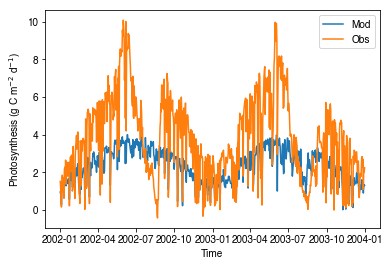

In [25]:
plt.plot(df_mod.GPP, label="Mod")
plt.plot(df_obs.GPP, label="Obs")
plt.legend(numpoints=1, loc='best')
plt.ylabel("Photosynthesis (g C m$^{-2}$ d$^{-1}$)")
plt.xlabel("Time")
plt.show()

Our simple model doesn't do that bad a job at simulating GPP at a larger scale, nevertheless there are some notable periods of divergence.

**Q. Why do you think the model underestimate GPP during the peak of summer?**

**Q. Why do you think the model overestimates GPP after July?**

***

## Can we make a simpler model of GPP?

In contrast to the complicated leaf photosynthesis model following Farquhar, we could use a much simpler light use efficiency (LUE) model to estimate GPP. The LUE model predicts that GPP is directly proportional to the absorbed PAR,.

$$GPP = \epsilon * fPAR * PAR$$

where $\epsilon$ is the light use efficiency constant. The LUE model originated from work by John Monteith. @Mon72 suggested that the NPP of well-watered and fertilised annual crop plants was linearly related to the amount of solar energy the plants absorbed over a growing season. In a follow up study, @Mon77 observed linear relationships between above-ground NPP and APAR for different agricultural crops in Britain, leading him to suggest that $\epsilon$ was a conservative parameter. This LUE approach is used in combination with satellite data (e.g. MODIS) to model GPP at the global scale. In the satellite algorithm, $\epsilon$ (emax below) varies by vegetation type and is reduced with temperature and water stress (via VPD scalar).

Let's generate a LUE, similar to the MODIS model and apply it at our flux site.


In [26]:
# PAR half of SW (W m-2 -> J m-2 s-1 -> MJ m-2 30 min-1)
conv = 0.5 * c.J_TO_MJ * c.SEC_2_HLFHR

In [27]:
PAR = SWdown * conv
PAR = PAR.resample("D").sum()

**Q. Can you do the same for vpd and Tair, taking the mean instead?**

Answer:

In [28]:
Tair = Tair.resample("D").mean() - c.DEG_2_KELVIN
vpd = vpd.resample("D").mean()

Let's generate the LUE inputs:

In [29]:
T_scal = (Tair - min(Tair)) / (max(Tair) - min(Tair))
D_scal = (vpd - min(vpd)) / (max(vpd) - min(vpd))

# You should play with this value and see how your plot changes, can you predict
# the impact before you change this value?
emax = 1.0 # g C m-2 MJ-1 APAR

GPP_lue = calc_lue(fPAR, PAR, T_scal, D_scal, emax)
df_lue = pd.DataFrame(data=GPP_lue, index=Tair.index, columns=["GPP"])

**Q. Can you plot the obs, farquhar model and the LUE model on one plot?**

Answer:

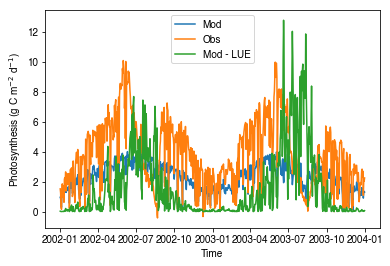

In [30]:
plt.plot(df_mod.GPP, label="Mod")
plt.plot(df_obs.GPP, label="Obs")
plt.plot(df_lue.GPP, label="Mod - LUE")
plt.legend(numpoints=1, loc='best')
plt.ylabel("Photosynthesis (g C m$^{-2}$ d$^{-1}$)")
plt.xlabel("Time")
plt.show()

**Q. By comparing the simple LUE model with our more complicated model, can we spot any weaknesses in the model assumptions?**

**Q. Why does the LUE have a much stronger seasonality? What assumption do you think drive this?**

**Q. Can you test what you think the cause is by adjusting the LUE equation?**

***

## Response to global change

The plots you've made should have given you some insight into how photosynthesis will respond to changes in temperature and [CO~2~]. This is very powerful as it means you should now have a sense of what a climate model will simulate will happen to GPP in the future.

**Q. Given your new insights, what do you predict will happen to carbon uptake if [CO~2~] keeps increasing?**

**Q. What will happen in response to increasing temperature?**

You can probably also make an informed guess about some of the factors that we haven't accounted for in this model.

**Q. What does the photosynthesis model predict happens in a drought?**

**Q. The model predicts and instantaneous response to temperature but what about acclimation to temperature?**

Bonus question if you finish all of that.

**Q. The plot shows the impact of the third limitation, triose phosphate utilisation (TPU) - look above 900 umol mol-1. Most models do not include this, can you think of the pros and cons of not doing so?**

![](data/tpu.png)







